# Imports

In [ ]:
!pip install transformers

In [ ]:
import csv
import torch
import numpy as np
import random
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available()
else 'cpu')

# Download Data

Dataset is based on [MELD](https://github.com/declare-lab/MELD). We will only keep utterances and sentiment, i.e. have each row like :

* ["Oh my God, he’s lost it. He’s totally lost it.", "negative"]
* ["Or! Or, we could go to the bank, close our accounts and cut them off at the source.",  "neutral"]
* ["You’re a genius!", "positive"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_folder = "/content/drive/Shareddrives/PFE ING3 IA NISSAN/Ressources/sentiment_analysis/data/"

datasets = {
    x: {'sentences': [], 'labels': [], 'input_ids': [], 'attention_masks': []} for x in ['train', 'dev', 'test']
}

label_names = ['positive','negative','neutral']

def define_label(label):
    if label == 'positive':
        return 0
    elif label == 'negative':
        return 1
    else:
        return 2

with open(data_folder + "train.csv", 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=",")
    for row in csv_reader:
        datasets['train']['sentences'].append(row[0])
        datasets['train']['labels'].append(define_label(row[1]))

with open(data_folder + "dev.csv", 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=",")
    for row in csv_reader:
        datasets['dev']['sentences'].append(row[0])
        datasets['dev']['labels'].append(define_label(row[1]))
                                      
with open(data_folder + "test.csv", 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=",")
    for row in csv_reader:
        datasets['test']['sentences'].append(row[0])
        datasets['test']['labels'].append(define_label(row[1]))

# Tokenization and input formatting

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_len = 0

for sent in datasets['train']['sentences']:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Max sentence length:  95


In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs.
for data in ['train', 'dev', 'test']:

    for sent in datasets[data]['sentences']:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
        
        # Add the encoded sentence to the list.    
        datasets[data]['input_ids'].append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        datasets[data]['attention_masks'].append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    datasets[data]['input_ids'] = torch.cat(datasets[data]['input_ids'], dim=0)
    datasets[data]['attention_masks'] = torch.cat(datasets[data]['attention_masks'], dim=0)
    datasets[data]['labels'] = torch.tensor(datasets[data]['labels'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Print sentence 0, now as a list of IDs.
print('Original: ', datasets['train']['sentences'][0])
print('Token IDs:', datasets['train']['input_ids'][0])
print('Attention mask:', datasets['train']['attention_masks'][0])
print('Label:', datasets['train']['labels'][0])

Original:  also I was the point person on my company’s transition from the KL-5 to GR-6 system.
Token IDs: tensor([  101,  2036,  1045,  2001,  1996,  2391,  2711,  2006,  2026,  2194,
         1521,  1055,  6653,  2013,  1996,  1047,  2140,  1011,  1019,  2000,
        24665,  1011,  1020,  2291,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])
Attention mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# Combine the inputs into a TensorDataset.
train_dataset = TensorDataset(datasets['train']['input_ids'], datasets['train']['attention_masks'], datasets['train']['labels'])
validation_dataset = TensorDataset(datasets['dev']['input_ids'], datasets['dev']['attention_masks'], datasets['dev']['labels'])

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.

# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            validation_dataset, # The validation samples.
            sampler = SequentialSampler(validation_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Model definition

Our model is based on BERT, applied to sentiment classification.

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Freeze all layers
#for param in model.parameters():
#    param.requires_grad = False

#model.bert.encoder.layer[10:12].requires_grad = True
#model.bert.pooler.requires_grad = True
#model.classifier.requires_grad = True

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Training model

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Function for formatting elapsed time as hh::mm::ss
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
#seed_val = 99

#random.seed(seed_val)
#np.random.seed(seed_val)
#torch.manual_seed(seed_val)
#torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += outputs.loss.item()

        # Perform a backward pass to calculate the gradients.
        outputs.loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += outputs.loss.item()

        # Move logits and labels to CPU
        outputs.logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(outputs.logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    313.    Elapsed: 0:00:19.
  Batch    80  of    313.    Elapsed: 0:00:38.
  Batch   120  of    313.    Elapsed: 0:00:58.
  Batch   160  of    313.    Elapsed: 0:01:17.
  Batch   200  of    313.    Elapsed: 0:01:37.
  Batch   240  of    313.    Elapsed: 0:01:57.
  Batch   280  of    313.    Elapsed: 0:02:17.

  Average training loss: 0.86
  Training epoch took: 0:02:34

Running Validation...
  Accuracy: 0.67
  Validation Loss: 0.77
  Validation took: 0:00:06

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    313.    Elapsed: 0:00:20.
  Batch    80  of    313.    Elapsed: 0:00:41.
  Batch   120  of    313.    Elapsed: 0:01:01.
  Batch   160  of    313.    Elapsed: 0:01:22.
  Batch   200  of    313.    Elapsed: 0:01:42.
  Batch   240  of    313.    Elapsed: 0:02:03.
  Batch   280  of    313.    Elapsed: 0:02:23.

  Average training loss: 0.71
  Training epoch took: 0:02:40

Running Validation...
  Accuracy: 0.68
 

# Performances

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df_stats = df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.86,0.77,0.67,0:02:34,0:00:06
2,0.71,0.76,0.68,0:02:40,0:00:06


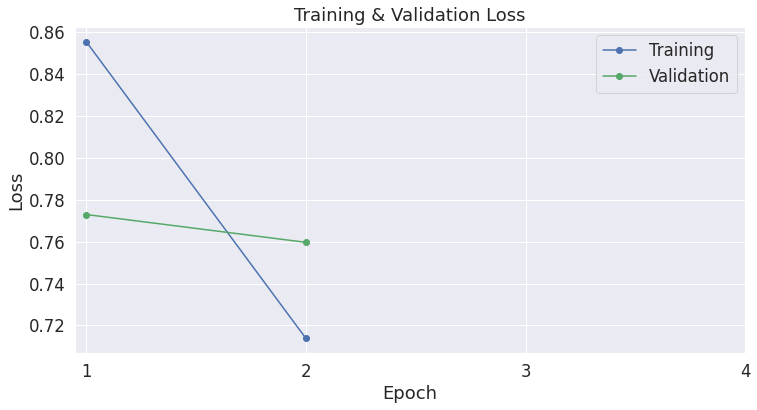

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Evaluation on Test set

In [ ]:
test_dataset = TensorDataset(datasets['test']['input_ids'], datasets['test']['attention_masks'], datasets['test']['labels'])

test_dataloader = DataLoader(
            test_dataset, 
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size 
        )

In [ ]:
model.eval()

total_test_accuracy = 0
for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  outputs.logits = outputs.logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  total_test_accuracy += flat_accuracy(outputs.logits, label_ids)

In [ ]:
avg_test_accuracy = total_test_accuracy / len(test_dataloader)
print("  Accuracy: {0:.2f}".format(avg_test_accuracy))

  Accuracy: 0.71


# Save model

In [ ]:
import os

output_dir = "/content/drive/Shareddrives/PFE ING3 IA NISSAN/Ressources/sentiment_analysis/model"

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to /content/drive/Shareddrives/PFE ING3 IA NISSAN/Ressources/sentiment_analysis/model


('/content/drive/Shareddrives/PFE ING3 IA NISSAN/Ressources/sentiment_analysis/model/tokenizer_config.json',
 '/content/drive/Shareddrives/PFE ING3 IA NISSAN/Ressources/sentiment_analysis/model/special_tokens_map.json',
 '/content/drive/Shareddrives/PFE ING3 IA NISSAN/Ressources/sentiment_analysis/model/vocab.txt',
 '/content/drive/Shareddrives/PFE ING3 IA NISSAN/Ressources/sentiment_analysis/model/added_tokens.json')